# Wine Neural Network
### QMIND
### Cameron Khalili

## Part 1: Import Necessary Modules

In [9]:
#used for dataprocessing
import pandas as pd
import numpy as np

#Used keras to create the neural network model
from keras import layers, optimizers, regularizers
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.models import Sequential
import keras.backend as K

#used matplotlib for all of the plotting
import matplotlib.pyplot as plt

#used to create the confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

#Used to save figures
from matplotlib.backends.backend_pdf import PdfPages

## Part 2: Import Wine Data

In [2]:
#imports the wine data from a csv and breaks it up into x and y values
wine_data = pd.read_csv('wine_quality_data.csv').values#imports wine quality data csv
wd = pd.read_csv('wine_quality_data.csv')
w_sols = wd['quality']#Trying to predict the quality of the wine
x_df_data = wd.copy().drop(columns = ['quality'])#copies array to avoid aliasing and drops the quality column

## Part 3: Preprocess Wine Data

In [3]:
#makes an array of all the possible outputs and puts a 1 in the correct output
def output_list(answers, num_options, ans_offset):
    output = []#creates a list of np arrays
    for i in range (len(answers)):
        temp = np.zeros(num_options)#initializes to 0s and sets the answer to 1
        temp[answers[i] - ans_offset] = 1
        output.append(temp)
    return np.array(output)#casts the list as a numpy array and returns all of the answers in the new form

y_data = output_list(w_sols, 6, 3)#gets the output data in a form that makes sense

In [4]:
#Normalizes each set of data going into the neural net
headers = x_df_data.columns.values#gets all of the types of data from the headers of the dataframe
for i in range(len(headers)):
    max_val = max(x_df_data[headers[i]])#uses a max and min val to normalize data
    min_val = min(x_df_data[headers[i]])
    x_df_data[headers[i]] = (x_df_data[headers[i]] - min_val)/(max_val-min_val+0.0)
x_data = x_df_data.values#gets the data into a 2d numpy array

## Part 4: Supervised Learning Model

In [5]:
#Uses an Adam Optimizer for training
Adam_opt = optimizers.Adam(lr=0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-88, decay=0.0)

#initializes the model with the keras module Sequential
model = Sequential()

#1st Layer
model.add(layers.Dense(50, input_dim=11, activation = "sigmoid"))

#2nd Layer
model.add(layers.Dense(100, name = 'layer2', bias_initializer='zeros'))
model.add(Activation('sigmoid'))
          
#3rd Layer
model.add(layers.Dense(100, name = 'layer3', bias_initializer='zeros'))
model.add(Activation('sigmoid'))

#Output layer
model.add(layers.Dense(6, name = 'layer4', bias_initializer='zeros'))
model.add(Activation('softmax'))

#Sets up Adam Optimizer and compiles the model
Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer = Adam, loss = "categorical_crossentropy", metrics = ["categorical_accuracy"])#compiles model

#Keeps track of the history for data analytics
#Runs the model through the dataset
history = model.fit(x = x_data, y = y_data, validation_split=0.3, epochs = 80, batch_size = 50, verbose = 0)

## Part 5: Data Analysis

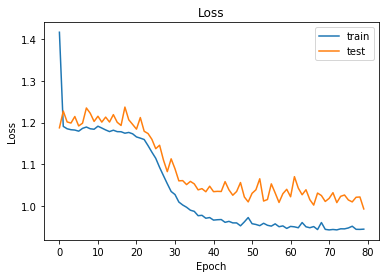

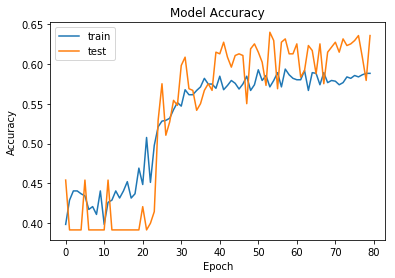

In [13]:
pp = PdfPages('Wine_Neural_Net_Plots.pdf')#creates pdf to save figures

#Plots the loss of the agent for the training and testing data for each epoch
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['train', 'test'], loc='upper right')
plt.savefig(pp, format='pdf')#appends the figure to the pdf

#Plots the accuracy of the agent for the training and testing data for each epoch
plt.figure()
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(pp, format='pdf')#appends the figure to the pdf

pp.close()#closes the pdf and saves it

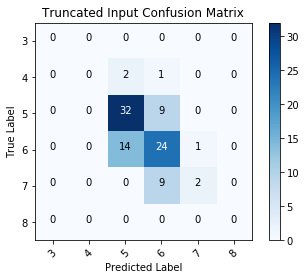

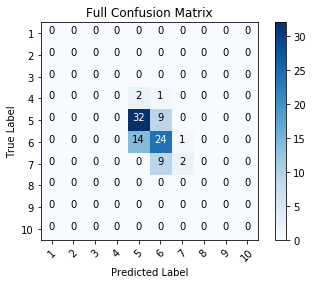

In [11]:
#The NN was simplified so it only output ratings 3-8. 
#This adds the extra rows and columns to the confusion matrix so it contains everything from 1-10
def add_dims(matrix, num_at_beginning, num_at_end):
    #takes in the matrix, the number of low ratings not included, and the number of high ratings not included
    
    #creates a np array of zeros with the correct length
    temp = list(np.zeros(len(matrix[0])+num_at_beginning+num_at_end))
    return_matrix = []#sets up matrix which is getting returned
    for i in range(num_at_beginning):#sets up the low rows of the matrix with no values as 0s
        return_matrix.append(temp)
        
    #sets up an array of 0s to add to the current data
    beginning_zeros = list(np.zeros(num_at_beginning))
    ending_zeros = list(np.zeros(num_at_end))
    for i in range(len(matrix)):
        return_matrix.append(beginning_zeros + list(matrix[i]) + ending_zeros)#makes a full row with the smaller matrix & 0s
    
    #Adds a set of zero arrays at the end of the matrix
    for i in range(num_at_end):
        return_matrix.append(temp)
        
    return np.array(return_matrix).astype(int)

#Takes in the confusion matrix and plots it
def plot_conf_matrix(cm, classes, in_percent=True, title='Confusion Matrix', cmap=plt.cm.Blues):
    #takes in the confusion matrix (cm), the class names, if the values should be reported in %, the title, and the color
    
    #gets the data in percent if specified by the user
    if in_percent:
        num_trials = sum(sum(cm))#gets the total number of values
        cm = 100*((cm+0.0)/num_trials)#gets the values in %
        cm = np.array(cm).astype(int)#makes each value an integer
    
    #Sets up the figure with title, tickmarks, axis labels,and a colorbar legend
    plt.figure()
    plt.imshow(cm,interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))#sets up tick marks with labels
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    
    #uses threshold for determining text color
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):#creates plot with text in it
        plt.text(j, i, cm[i,j], horizontalalignment = "center", color="white" if cm[i,j] > thresh else "black")

predictions = model.predict(x_data, batch_size=10, verbose=0)#Gets the predictions for the confusion matrix

#takes each output of the NN and uses the max value as the decision
predict = []
for i in range (len(predictions)):
    predict.append(list(predictions[i]).index(max(predictions[i])))

#takes the given solution from the csv and subtracts 3 because there were no output neurons for the first ratings 1 and 2
expected_nn_output = w_sols-3

cm = confusion_matrix(expected_nn_output, predict)
full_cm = add_dims(cm,2,2)

pp = PdfPages('Wine_Confusion_Matricies.pdf')#creates pdf to save figures
plot_conf_matrix(cm, np.array([3,4,5,6,7,8]), True, "Truncated Input Confusion Matrix")
plt.savefig(pp, format='pdf')#appends the figure to the pdf
plot_conf_matrix(full_cm, np.array([1,2,3,4,5,6,7,8,9,10]), True, "Full Confusion Matrix")
plt.savefig(pp, format='pdf')#appends the figure to the pdf
pp.close()#closes the pdf and saves it